In [1]:
from IPython.display import HTML
import pandas as pd

# 18 gecs: Improving Rigid Body Physics Simulations using LCPs

## Problem Description

Rigid body physics simulations, which approximate real-world objects as nondeformable distributions of mass, are frequently used in video games and other computer animations to produce reasonable-looking approximations of actual physics. A variety of techniques exist for modeling the interactions of rigid bodies; this project deals with the implementation of a collision management system called "speculative contacts." We chose this system because it has the following desirable properties:

1. It is a "continuous" collision management system; i.e., no matter how fast objects are moving, they won't teleport through other objects.
2. It supports "stable stacks;" i.e., multiple objects can be in a constantly colliding state without having a "jittery" appearance.
3. Unlike most collision management systems with properties 1. and 2., it is simple to describe and implement.

It can be described as follows:
* At the beginning of each timestep, the simulation is broken down into a set of “contacts.” A contact represents two points that might collide with one another. If the two points’ movements during this timestep (as determined by their objects’ velocities) overlap when projected onto the line connecting the two points (the “normal” line), the contact is in a “colliding” state.
* Colliding contacts are "fixed" in a physically reasonable manner by applying some impulse $i$ to both points along their normal line such that both points "repel" one another, and do so *just* enough that their movements during this timestep no longer overlap when projected onto the normal line. Excess repulsion is called "overcorrection."
* Before the simulation is advanced to the next timestep, all collisions must be fixed without any overcorrection.

### Data

Our optimization problem makes a multistage deterministic decision using a quadratic solver as described [here](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)
    
    
### Inputs
* `position`: the x, y position of each gec (ball) before the movement captured in the time step
* `velocity`: the x, y velocity of each gec before the alteration done in the time step
* `acceleration`: the x, y acceleration of each gec before the alteration done in the time step
* `mass`: the physical mass of each gec
* `radius`: the radius of each gec

### Outputs
* `impulse`: a concept in physics described below. The impulse is given in terms of each pair of gecs, which corresponds to each possible collision. At the end of the time step, an impulse is applied to each gec for the computed value for each pair it is in. This can be roughly thought of as the amount each gec in the pair repels the other to avoid collision. The impulse vector acts as `x` in the qcp problem


https://www.khanacademy.org/science/physics/linear-momentum/momentum-tutorial/a/what-are-momentum-and-impulse

### Constraints
* Non-anticipativity: the decision at time t can only depend on the input state up until time t.
* Positive impulse: gecs can only create a force pushing other gecs away.
* Collisions: gecs cannot pass through each other. If the current trajectory will send 2 gecs into an illegal state before the next time step, their routes must be altered

### Objective
* In the greedy implementation visualization, observe that a lot of bouncing happens, and it takes a long time for the simulation to stabalize. The goal is to reduce bouncing to accurately simulate a collision with minimal elasticity. The problem has been formulated so that bouncing is reflected by the objective function:

$$
\textrm{minimize } (1/2)x^TPx + q^Tx
$$


## Our Approach


We compared the following implementations of speculative contacts:
* `greedy` - At the beginning of every timestep, look at every contact sequentially. When you find a colliding contact, apply an repelling impulse $i$ to both bodies such that the contact is no longer colliding, and has no overcorrection.
* `greedyWithCorrections(k)` - At the beginning of every timestep, run `greedy`. Then, look through every contact again, fixing collisions a la `greedy`, but also detecting and fixing overcorrection (if a contact has had some $i$ applied to it and the distance between its points at the start of the next timestep will be greater than zero, it is overcorrected; this is fixed by applying an attractive impulse $i'$ to both bodies such that the total impulse applied is still nonattractive, but the points' distance at the start of the next timestep will be as close to zero as possible). This iterate-and-fix-overcorrection strategy is repeated `k` times - the idea is that as `k` increases, the result gets less and less wrong.
* `LCP` - Determine the $i$ to apply to each contact by solving the following LCP:

$$
\textrm{minimize } (1/2)x^TPx + q^Tx
$$
$$
\textrm{subject to } Gx \leq h
$$
* $x$ contains the $i$ to apply to each contact; $x_j > 0 \implies$ a repelling impulse; $x_j < 0 \implies$ an attractive impulse
* $G$ is of dimension $2|x|$ by $|x|$; it can be thought of as two $|x|$ by $|x|$ matrices stacked vertically:
    * The top matrix $T$ is such that $Tx$ produces a vector $v$ where $v_j$ is the net change in the normal velocity of the contact represented by $x_j$ ($v_j > 0 \implies$ its points were pushed towards each other and $v_j < 0 \implies$ its points were pushed away from each other).
    * The bottom matrix is the identity matrix multiplied by $-1$.
* $h$ is a vector of cardinality $2|x|$; it can be thought of as two vectors of cardinality $|x|$ stacked vertically:
    * The top vector $t$ is such that $t_j$ is the "normal velocity cushion" of the contact represented by $x_j$ before applying any impulses ($t_j > 0 \implies$ its points can be pushed toward each other by up to $t_j$ and $t_j < 0 \implies$ its points must be pushed away from each other by at least $t_j$). It is computed as $t_j = \textrm{velocityDifference}(x_j)\cdot\textrm{unitNormalVector}(x_j) + \textrm{distance}(x_j)*\textrm{timestep}$.
    * The bottom vector is the zero vector.
* Therefore, the effects of the $Gx \leq h$ constraint are that:
    * The net change in normal velocity of each contact will be such that the no contacts end in a colliding state.
    * All impulses applied to contacts will be nonattractive.
* $P$ is an $|x|$ by $|x|$ matrix equal to $-2T$.
* $q$ is a vector of cardinality $|x|$ equal to $t$.
* The objective can therefore rewritten as $x \cdot (-Tx + t)$.
* This is equivalent to $x \cdot \textrm{(normal velocity cushion of the contact represented by } x_j \textrm{ after applying all impulses, guranteed to be nonnegative by the constraint)}$.
* Minimizing this minimizes overcorrection because the solver will minimize the cushion of all contacts that have had corrections applied to them (contacts that haven't had corrections applied to them have $x_j = 0$, so it won't need to minimize those cushions).

We implemented all three of these methods in Python (using the [cvxopt.qp](https://cvxopt.org/userguide/coneprog.html#quadratic-programming) solver for `LCP`). To to stress-test their support for fast-moving objects and stable stacks, we had them simulate the high-speed stacking of 18 two-dimensional discs. Henceforth, these discs will be referred to as "gecs" in tribute to the experimental pop band [100 gecs](https://en.wikipedia.org/wiki/100_Gecs). See an [example of their work](https://soundcloud.com/100gecs/stupid-horse).

### Python Code

    import numpy as np
    import random
    import time
    import json
    import cvxopt
    cvxopt.solvers.options['show_progress'] = False

    timestep = 1/30
    inverseTimestep = 1/timestep

    class Gec:

        def __init__(self, mass=None, radius=None, color=None, 
                     position=None, velocity=(0, 0), acceleration=(0, 0)):

            assert mass is not None
            self.inverseMass = 1 / mass

            assert radius is not None
            self.radius = radius

            assert color is not None
            self.color = color

            assert position is not None
            self.position = np.array(position).astype(float)

            self.velocity = np.array(velocity).astype(float)

            self.acceleration = np.array(acceleration).astype(float)

        def advance(self):

            self.position += self.velocity * timestep
            self.velocity += self.acceleration * timestep

        def applyImpulse(self, impulseVector):

            self.velocity += impulseVector * self.inverseMass

    class GecPair:

        def __init__(self, aGec, bGec):

            self.aGec = aGec
            self.bGec = bGec
            self.inverseMassScalar = self.aGec.inverseMass + self.bGec.inverseMass
            self._massScalar = 1 / self.inverseMassScalar
            self._radiiSum = self.aGec.radius + self.bGec.radius
            self.advance()

        def advance(self):

            centerDifference = self.bGec.position - self.aGec.position
            centerDistance = np.linalg.norm(centerDifference)
            self._direction = centerDifference / centerDistance
            self._distanceComponentOfVelocityCushion = (
                (centerDistance - self._radiiSum) * inverseTimestep
                )
            self._appliedImpulse = 0

        def getVelocityCushion(self):
            # if negative: how much you need to fix it in velocity units
            # if positive: how much extra velocity

            return (
                # distance component: vel needed to colide ina time stop

                self._distanceComponentOfVelocityCushion + 
                np.dot(self.bGec.velocity - self.aGec.velocity, self._direction)
                #^ negative => moving closer to each other, 
                #  positive => moving farther away from each other
                )

        def applyImpulse(self, impulseScalar):

            impulseVector = self._direction * impulseScalar
            self.aGec.applyImpulse(impulseVector)
            self.bGec.applyImpulse(-impulseVector)
            self._appliedImpulse += impulseScalar

        def fixVelocity(self):
        #^ used to compute approximate results

            self.applyImpulse(min(
                self._massScalar * self.getVelocityCushion() + self._appliedImpulse, 
                0.0,
                ) - self._appliedImpulse)

        def getImpulseToVelocityScalar(self, other, sharedGec):
        #^ used to compute optimal results

            return (
                (1.0 if ((sharedGec == self.aGec and sharedGec == other.aGec) 
                or (sharedGec == self.bGec and sharedGec == other.bGec)) 
                else -1.0) * 
                sharedGec.inverseMass * 
                np.dot(self._direction, other._direction)
                )

    def getGecPairs(gecs):
        return tuple(
            GecPair(gecs[i], gecs[j]) 
            for i in range(len(gecs)) 
            for j in range(i+1, len(gecs))
            if gecs[i].inverseMass != 0 or gecs[j].inverseMass != 0
            )

    resolution = (1280, 720)

    def getTestGecs():
        white = (1.0, 1.0, 1.0, 1.0)
        purple = (0.9, 0.0, 0.9, 1.0)
        green = (0.0, 0.9, 0.0, 1.0)
        bigRadius = resolution[0]/4
        bigOffset = resolution[0]/8
        gecs = [
            Gec(mass=float("Infinity"), radius=bigRadius-bigOffset, color=white,
                position=(resolution[0]/2, 0)),
            ]
        radius = 15
        for i in range(int((resolution[1]-(bigRadius-bigOffset))/(2*radius))):
            gecs.append(Gec(mass=1, radius=radius, color=purple, 
                position=(resolution[0]/2, (bigRadius-bigOffset)+(i+1)*(2*radius+75)),
                acceleration=(0, -250),
                ))
        return gecs

    def storeResults(gecs, stepGecPositions, testName, computeTime):
        with open("results/" + testName + ".json", "w") as resultFile:
            json.dump({
                "computeTime": computeTime,
                "gecCount": len(gecs),
                "gecRadii": [g.radius for g in gecs],
                "gecColors": [g.color for g in gecs],
                "timestep": timestep,
                "stepCount": simulationSteps,
                "resolution": resolution,
                "stepGecPositions": stepGecPositions,
                }, resultFile)

    simulationTime = 20
    simulationSteps = int(simulationTime / timestep)

    testName = "coarseApproximation"
    startTime = time.time()
    gecs = getTestGecs()
    gecPairs = getGecPairs(gecs)
    stepGecPositions = []
    for i in range(simulationSteps):
        print(str(round(i/simulationSteps*100, 2))+"%", "through", testName)
        stepGecPositions.append([])
        for g in gecs:
            stepGecPositions[-1].append(tuple(g.position))
        for j in range(1):
        #^ for the coarsest approximation, only do 1 iteration
            for p in gecPairs:
                p.fixVelocity()
        for g in gecs:
            g.advance()
        for p in gecPairs:
            p.advance()
    storeResults(gecs, stepGecPositions, testName, time.time()-startTime)

    testName = "fineApproximation"
    startTime = time.time()
    gecs = getTestGecs()
    gecPairs = getGecPairs(gecs)
    stepGecPositions = []
    for i in range(simulationSteps):
        print(str(round(i/simulationSteps*100, 2))+"%", "through", testName)
        stepGecPositions.append([])
        for g in gecs:
            stepGecPositions[-1].append(tuple(g.position))
        for j in range(4):
        #^ for the finer approximation, do 4 iterations
            for p in gecPairs:
                p.fixVelocity()
        for g in gecs:
            g.advance()
        for p in gecPairs:
            p.advance()
    storeResults(gecs, stepGecPositions, testName, time.time()-startTime)

    testName = "optimal"
    # the part done in gams
    startTime = time.time()
    gecs = getTestGecs()
    gecPairs = getGecPairs(gecs)
    gecPairsWithGec = {
        g: tuple((i, p) for i, p in enumerate(gecPairs) if p.aGec == g or p.bGec == g)
        for g in gecs
        }

    # 7 is arbitrary
    q = cvxopt.matrix(7.0, (len(gecPairs), 1))

    # 0 is not
    h = cvxopt.matrix(0.0, (2*len(gecPairs), 1))
    P = cvxopt.spmatrix([], [], [], (len(gecPairs), len(gecPairs)))
    G = cvxopt.spmatrix([], [], [], (len(gecPairs)*2, len(gecPairs)))
    for i, p in enumerate(gecPairs):
        P[i, i] = 2*p.inverseMassScalar

        # div by mass converts impuse into velocity change
        G[i, i] = -p.inverseMassScalar
        G[i+len(gecPairs), i] = -1.0
    stepGecPositions = []
    for i in range(simulationSteps):
        print(str(round(i/simulationSteps*100, 2))+"%", "through", testName)
        stepGecPositions.append([])
        for g in gecs:
            stepGecPositions[-1].append(tuple(g.position))
        for j, p in enumerate(gecPairs):
            cushion = p.getVelocityCushion()
            q[j] = cushion
            h[j] = cushion
            for k, otherP in gecPairsWithGec[p.aGec]:
                if j != k:
                    scalar = p.getImpulseToVelocityScalar(otherP, p.aGec)
                    doubleScalar = 2*scalar
                    P[j, k] = doubleScalar
                    P[k, j] = -doubleScalar
                    G[j, k] = -scalar
                    G[k, j] = scalar
            for k, otherP in gecPairsWithGec[p.bGec]:
                if j != k:
                    scalar = p.getImpulseToVelocityScalar(otherP, p.bGec)
                    doubleScalar = 2*scalar
                    P[j, k] = doubleScalar
                    P[k, j] = -doubleScalar
                    G[j, k] = -scalar
                    G[k, j] = scalar
        for p, impulse in zip(gecPairs, cvxopt.solvers.qp(P, q, G=G, h=h)["x"]):
            p.applyImpulse(-impulse)
        for g in gecs:
            g.advance()
        for p in gecPairs:
            p.advance()
    storeResults(gecs, stepGecPositions, testName, time.time()-startTime)

### GAMS Code (to verify the results of the Python optimizer)

In [2]:
%load_ext gams_magic
import numpy as np

In [3]:
%%gams
Set tgc 'test get cols'
         gecs 'gecs'
         dir 'directions' /x, y/;


alias(gecs, g1, g2, g3, g4);

parameter d(gecs, tgc)
         resX  'resolution width'
         resY  'resolution height'
         timestep 'duration of timestep'
         inverseTimestep;
resX = 1280;
resY = 720;
timestep = 1/30;
inverseTimestep = 1/timestep;

variable finalPosition(g1);
variable finalVelocity(g1);


$call csv2gdx testGecsData.csv id=d index=1 values=2..lastCol useHeader=y trace=0
$ifE errorLevel<>0 $abort Problems reading testGecsData.csv!
$gdxIn testGecsData.gdx
$load gecs = dim1
$load tgc = dim2

$load d
$gdxIn


* velocity of a gec at the beginning of the time step
parameter velocity(g1, dir);
velocity(g1, 'x') = d(g1, 'velocityx');
velocity(g1, 'y') = d(g1, 'velocityy');

Set gecPair(g1, g2);

* pairs of valid gecPairs (including duplicates)
Set gecPairPair(g1, g2, g3, g4);

gecPair(g1, g2) $(ord(g1)>ord(g2) and ord(g1)<>20 and ord(g2)<>20)=YES;

gecPairPair(g1, g2, g3, g4) $(gecPair(g1, g2)and gecPair(g3, g4))=YES;

* the pairs (g2, g3) containing g1
Set gecPairsWithGec(g1, g2, g3);
gecPairsWithGec(g1, g2, g3) $((ord(g1)=ord(g2) or ord(g1)=ord(g3)) and ord(g2)>ord(g3))=YES;

* inverseMassScalar for each gecPair
parameter pairInverseMassScalar(g1, g2);
pairInverseMassScalar(g1, g2) $gecPair(g1, g2) = d(g1, 'inverseMass') + d(g2, 'inverseMass');


* _massScalar for each gecPair
parameter pair_massScalar(g1, g2);
* max in place to avoid /0 error for trivial calculations, which should not occur
pair_massScalar(g1, g2) $gecPair(g1, g2) = 1 / max(pairInverseMassScalar(g1, g2), 0.00001);

* _radiiSum for each gecPair
parameter pair_radiiSum(g1, g2);
pair_radiiSum(g1, g2) $gecPair(g1, g2) = d(g1, 'radius') + d(g2, 'radius');

* run GecPair.advance()
* actual distances between the centers in x and y components
parameter centerDifference(g1, g2, dir);
centerDifference(g1, g2, 'x')  $gecPair(g1, g2) =  d(g2, 'positionx') - d(g1, 'positionx') ;
centerDifference(g1, g2, 'y')  $gecPair(g1, g2) =  d(g2, 'positiony') - d(g1, 'positiony') ;

* actual distances between the centers
parameter centerDistance(g1, g2);
centerDistance(g1, g2)  $gecPair(g1, g2) =  sqrt(sum(dir, sqr(centerDifference(g1, g2, dir)))) ;

* unit-scaled distance between centers in x and y components
parameter pair_direction(g1, g2, dir) ;
pair_direction(g1, g2, dir)  $gecPair(g1, g2) = centerDifference(g1, g2, dir) / centerDistance(g1, g2);

parameter pair_distanceComponentOfVelocityCushion(g1, g2);
pair_distanceComponentOfVelocityCushion(g1, g2) $gecPair(g1, g2) =  (centerDistance(g1, g2) -  pair_radiiSum(g1, g2)) * inverseTimestep;


* end of GecPair.advance()

* pairVelocityCushion is the amount of velocity that can be applied to a pair without them colliding.
* if negative: how much you need to fix it in velocity units
* if positive: how much extra velocity
parameter pairVelocityCushion(g1, g2);
pairVelocityCushion(g1, g2) = sum(dir, (velocity(g2, dir) -velocity(g1,dir)) *pair_direction(g1, g2, dir));



* q, h, G, P from cone form documentation
parameter q(g1,g2);
q(g1,g2) $gecPair(g1, g2) = pairVelocityCushion(g1, g2);
parameter h(g1,g2);
h(g1,g2) $gecPair(g1, g2) = pairVelocityCushion(g1, g2);

* P and G are 2d matricies of gecPairs
parameter P(g1,g2, g3, g4);
parameter G(g1,g2, g3, g4);

* diagonal entries in P,G
P(g1,g2, g3, g4) $(gecPairPair(g1, g2, g3, g4) and ord(g1)=ord(g3) and ord(g2)=ord(g4)) = 2 * pairInverseMassScalar(g1, g2);
G(g1,g2, g3, g4) $(gecPairPair(g1, g2, g3, g4) and ord(g1)=ord(g3) and ord(g2)=ord(g4)) = -1 * pairInverseMassScalar(g1, g2);


* pairs of pairs that share a gec (aGec)
* calculate how much impule affects otherP's velocity
P(g1,g2, g3, g4) $(ord(g1)=ord(g3) and ord(g2)<>ord(g4)) =  2 * d(g1, 'inverseMass') * sum(dir, pair_direction(g1, g2, dir)*pair_direction(g3, g4, dir));
P(g1,g2, g3, g4) $(ord(g1)=ord(g4))                      = -2 * d(g1, 'inverseMass') * sum(dir, pair_direction(g1, g2, dir)*pair_direction(g3, g4, dir));

G(g1,g2, g3, g4) $(ord(g1)=ord(g3) and ord(g2)<>ord(g4)) = -1 * d(g1, 'inverseMass') * sum(dir, pair_direction(g1, g2, dir)*pair_direction(g3, g4, dir));
G(g1,g2, g3, g4) $(ord(g1)=ord(g4))                      =      d(g1, 'inverseMass') * sum(dir, pair_direction(g1, g2, dir)*pair_direction(g3, g4, dir));


* _appliedImpulse for the pair (the amount of physical impulse )
* this is x in the cone problem
variable pair_appliedImpulse(g1, g2);
pair_appliedImpulse.lo(g1, g2) = 0;

* cone constraint   Gx <= h
equation
         st(g1, g2)
         getXtpx(g1, g2) 'get the (vector) product of x transpose and P and x'
         getObj;
st(g1, g2) $(gecPair(g1, g2))..  sum((g3, g4) $(gecPair(g1, g2) and gecPair(g3, g4) and (ord(g1)<>ord(g3) or ord(g2)<>ord(g4))), pair_appliedImpulse(g3, g4)) =g= h(g1, g2);

variable xtpx(g1, g2);
getXtpx(g1, g2).. Xtpx(g1, g2)$(gecPair(g1, g2)) =e= sum((g3, g4) $(gecPair(g1, g2) and gecPair(g3, g4) and (ord(g1)<>ord(g3) or ord(g2)<>ord(g4))), pair_appliedImpulse(g1, g2)*P(g1, g2, g3, g4))*pair_appliedImpulse(g1, g2);

variable obj;
getObj.. obj =e= sum((g1, g2)$(gecPair(g1, g2)) ,(0.5*xtpx(g1, g2) )+(q(g1, g2)*pair_appliedImpulse(g1, g2)));

display tgc, gecs, pairVelocityCushion;

model cone /all/;
solve cone using qcp minimizing obj;
display   obj.l, h, pair_appliedImpulse.l;



,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),0.0,343,343,QCP,CONOPT,0.006


at time step 1, there was no risk of collision so no velocities had to be modified
pair
g1g1      0.0
g1g2      0.0
g1g3      0.0
g1g4      0.0
g1g5      0.0
         ... 
g20g16    0.0
g20g17    0.0
g20g18    0.0
g20g19    0.0
g20g20    0.0
Name: impulse, Length: 400, dtype: float64


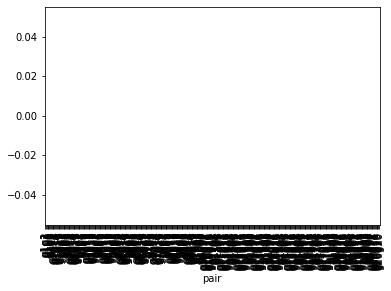

In [4]:
%gams_pull -d pair_appliedImpulse
%matplotlib inline
import pandas as pd
print("at time step 1, there was no risk of collision so no velocities had to be modified")

p = pd.DataFrame(pair_appliedImpulse)
p.columns = ['gecs1', 'gecs2', 'impulse', 'm', 'l', 'u', 's']
p['pair'] = p['gecs1'] + p['gecs2']
p = p.set_index('pair')
p = p['impulse']

print(p)
p.plot(kind="bar")

In [5]:
%%gams
Set tgc 'test get cols'
         gecs 'gecs'
         dir 'directions' /x, y/;


alias(gecs, g1, g2, g3, g4);

parameter d(gecs, tgc)
         resX  'resolution width'
         resY  'resolution height'
         timestep 'duration of timestep'
         inverseTimestep;
resX = 1280;
resY = 720;
timestep = 1/30;
inverseTimestep = 1/timestep;

variable finalPosition(g1);
variable finalVelocity(g1);


$call csv2gdx testGecsData50.csv id=d index=1 values=2..lastCol useHeader=y trace=0
$ifE errorLevel<>0 $abort Problems reading testGecsData50.csv!
$gdxIn testGecsData50.gdx
$load gecs = dim1
$load tgc = dim2

$load d
$gdxIn


* velocity of a gec at the beginning of the time step
parameter velocity(g1, dir);
velocity(g1, 'x') = d(g1, 'velocityx');
velocity(g1, 'y') = d(g1, 'velocityy');

Set gecPair(g1, g2);

* pairs of valid gecPairs (including duplicates)
Set gecPairPair(g1, g2, g3, g4);

gecPair(g1, g2) $(ord(g1)>ord(g2) and ord(g1)<>20 and ord(g2)<>20)=YES;

gecPairPair(g1, g2, g3, g4) $(gecPair(g1, g2)and gecPair(g3, g4))=YES;

* the pairs (g2, g3) containing g1
Set gecPairsWithGec(g1, g2, g3);
gecPairsWithGec(g1, g2, g3) $((ord(g1)=ord(g2) or ord(g1)=ord(g3)) and ord(g2)>ord(g3))=YES;

* inverseMassScalar for each gecPair
parameter pairInverseMassScalar(g1, g2);
pairInverseMassScalar(g1, g2) $gecPair(g1, g2) = d(g1, 'inverseMass') + d(g2, 'inverseMass');


* _massScalar for each gecPair
parameter pair_massScalar(g1, g2);
* max in place to avoid /0 error for trivial calculations, which should not occur
pair_massScalar(g1, g2) $gecPair(g1, g2) = 1 / max(pairInverseMassScalar(g1, g2), 0.00001);

* _radiiSum for each gecPair
parameter pair_radiiSum(g1, g2);
pair_radiiSum(g1, g2) $gecPair(g1, g2) = d(g1, 'radius') + d(g2, 'radius');

* run GecPair.advance()
* actual distances between the centers in x and y components
parameter centerDifference(g1, g2, dir);
centerDifference(g1, g2, 'x')  $gecPair(g1, g2) =  d(g2, 'positionx') - d(g1, 'positionx') ;
centerDifference(g1, g2, 'y')  $gecPair(g1, g2) =  d(g2, 'positiony') - d(g1, 'positiony') ;

* actual distances between the centers
parameter centerDistance(g1, g2);
centerDistance(g1, g2)  $gecPair(g1, g2) =  sqrt(sum(dir, sqr(centerDifference(g1, g2, dir)))) ;

* unit-scaled distance between centers in x and y components
parameter pair_direction(g1, g2, dir) ;
pair_direction(g1, g2, dir)  $gecPair(g1, g2) = centerDifference(g1, g2, dir) / centerDistance(g1, g2);

parameter pair_distanceComponentOfVelocityCushion(g1, g2);
pair_distanceComponentOfVelocityCushion(g1, g2) $gecPair(g1, g2) =  (centerDistance(g1, g2) -  pair_radiiSum(g1, g2)) * inverseTimestep;


* end of GecPair.advance()

* pairVelocityCushion is the amount of velocity that can be applied to a pair without them colliding.
* if negative: how much you need to fix it in velocity units
* if positive: how much extra velocity
parameter pairVelocityCushion(g1, g2);
pairVelocityCushion(g1, g2) = sum(dir, (velocity(g2, dir) -velocity(g1,dir)) *pair_direction(g1, g2, dir));



* q, h, G, P from cone form documentation
parameter q(g1,g2);
q(g1,g2) $gecPair(g1, g2) = pairVelocityCushion(g1, g2);
parameter h(g1,g2);
h(g1,g2) $gecPair(g1, g2) = pairVelocityCushion(g1, g2);

* P and G are 2d matricies of gecPairs
parameter P(g1,g2, g3, g4);
parameter G(g1,g2, g3, g4);

* diagonal entries in P,G
P(g1,g2, g3, g4) $(gecPairPair(g1, g2, g3, g4) and ord(g1)=ord(g3) and ord(g2)=ord(g4)) = 2 * pairInverseMassScalar(g1, g2);
G(g1,g2, g3, g4) $(gecPairPair(g1, g2, g3, g4) and ord(g1)=ord(g3) and ord(g2)=ord(g4)) = -1 * pairInverseMassScalar(g1, g2);


* pairs of pairs that share a gec (aGec)
* calculate how much impule affects otherP's velocity
P(g1,g2, g3, g4) $(ord(g1)=ord(g3) and ord(g2)<>ord(g4)) =  2 * d(g1, 'inverseMass') * sum(dir, pair_direction(g1, g2, dir)*pair_direction(g3, g4, dir));
P(g1,g2, g3, g4) $(ord(g1)=ord(g4))                      = -2 * d(g1, 'inverseMass') * sum(dir, pair_direction(g1, g2, dir)*pair_direction(g3, g4, dir));

G(g1,g2, g3, g4) $(ord(g1)=ord(g3) and ord(g2)<>ord(g4)) = -1 * d(g1, 'inverseMass') * sum(dir, pair_direction(g1, g2, dir)*pair_direction(g3, g4, dir));
G(g1,g2, g3, g4) $(ord(g1)=ord(g4))                      =      d(g1, 'inverseMass') * sum(dir, pair_direction(g1, g2, dir)*pair_direction(g3, g4, dir));


* _appliedImpulse for the pair (the amount of physical impulse )
* this is x in the cone problem
variable pair_appliedImpulse(g1, g2);
pair_appliedImpulse.lo(g1, g2) = 0;

* cone constraint   Gx <= h
equation
         st(g1, g2)
         getXtpx(g1, g2) 'get the (vector) product of x transpose and P and x'
         getObj;
st(g1, g2) $(gecPair(g1, g2))..  sum((g3, g4) $(gecPair(g1, g2) and gecPair(g3, g4) and (ord(g1)<>ord(g3) or ord(g2)<>ord(g4))), pair_appliedImpulse(g3, g4)) =g= h(g1, g2);

pair_appliedImpulse.up(g1, g2) = 200;
variable xtpx(g1, g2);
getXtpx(g1, g2).. Xtpx(g1, g2)$(gecPair(g1, g2)) =e= sum((g3, g4) $(gecPair(g1, g2) and gecPair(g3, g4) and (ord(g1)<>ord(g3) or ord(g2)<>ord(g4))), pair_appliedImpulse(g1, g2)*P(g1, g2, g3, g4))*pair_appliedImpulse(g1, g2);

variable obj;
getObj.. obj =e= sum((g1, g2)$(gecPair(g1, g2)) ,(0.5*xtpx(g1, g2) )+(q(g1, g2)*pair_appliedImpulse(g1, g2)));

display tgc, gecs, pairVelocityCushion;

model cone /all/;
solve cone using qcp minimizing obj;
display   obj.l, h, pair_appliedImpulse.l;



,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),OptimalLocal (2),-1.108683e+07,343,343,QCP,CONOPT,0.024


at time step 50,several impulses had to be applied. Their affects can be seen in the video
pair
g2g1      200.000000
g3g1      200.000000
g3g2      200.000000
g4g1      200.000000
g5g4      200.000000
             ...    
g19g2      12.112353
g19g3      11.682353
g19g4      13.194118
g19g5      13.194118
g19g10     12.500000
Name: impulse, Length: 88, dtype: float64


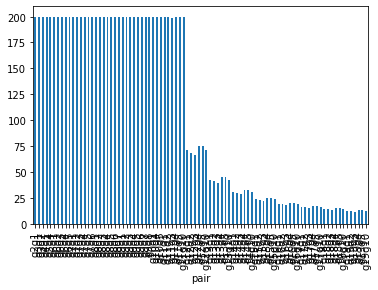

In [6]:
%gams_pull -d pair_appliedImpulse
%matplotlib inline
import pandas as pd
print("at time step 50,several impulses had to be applied. Their affects can be seen in the video")

p = pd.DataFrame(pair_appliedImpulse)
p.columns = ['gecs1', 'gecs2', 'impulse', 'm', 'l', 'u', 's']
p['pair'] = p['gecs1'] + p['gecs2']
p = p.set_index('pair')
p = p['impulse']
p = p[p>0]

print(p)
p.plot(kind="bar")

## Results

### Video Comparison

[greedy](https://gfycat.com/ifr/unlawfulbaggydalmatian?&hd=1&autoplay=0)

[greedyWithCorrections(3)](https://gfycat.com/ifr/ignorantgrandioseargusfish?&hd=1&autoplay=0)

[LCP](https://gfycat.com/ifr/athleticwanguanaco?&hd=1&autoplay=0)

### Runtime Comparison

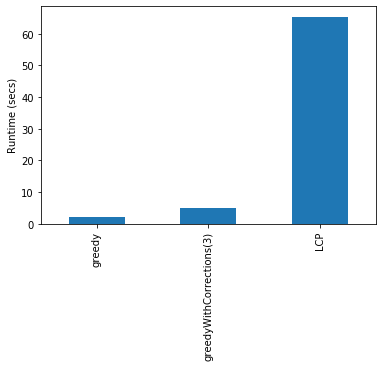

In [7]:
pd.DataFrame({
    "greedy": {"time": 1.981935977935791}, 
    "greedyWithCorrections(3)": {"time": 5.1059043407440186}, 
    "LCP": {"time": 65.4509379863739}
    }).transpose()["time"].plot(kind="bar").set_ylabel("Runtime (secs)")
pass

## Conclusions

`greedy` did the worst. It frequently violated the no-collisions rule, and the "bounciness" of stack implies violations of the no-overcorrection rule. It did run very fast, though.

`greedyWithCorrections(3)` did significantly better than `greedy`. The gecs overlapped much less, and the stack eventually stabilized after some less severe bouncing. However, it took ~2.5 times longer to run than `greedy`.

`optimal` did the best. The gecs almost never overlapped, and the stack stabilized very quickly. There was some *very* slight bounciness, though, which we think is due to the solver's solution being *slightly* suboptimal. Unfortuantely, it took ~30 times longer to run than `greedy` and ~12 times longer than `greedyWithCorrections(3)`. This makes sense, as just formulating the optimization problem is $O(n^3)$, whereas the greedy algorithms are only $O(n^2)$.

## Ideas for Future Work

* To make simulating larger number of gecs realistic, we'd need to add some kind of broadphase collision detection technique which doesn't require comparing every pair of gecs, such as [Sweep and Prune](https://www.math.ucsd.edu/~sbuss/ResearchWeb/EnhancedSweepPrune/SAP_paper_online.pdf).
* To make it able to simulate more complex rigid bodies, we'd need to allow for the rotation of objects, and therefore need to incorporate angular impulse into our collision model.